# Working with and visualising data

## Why write software to manage your data and plots? 

We can use programs for our entire research pipeline.

Not just big scientific simulation codes, but also the small scripts which we use to
tidy up data and produce plots. 

This should be code, so that the whole research pipeline
is recorded for reproducibility. Data manipulation in spreadsheets is much harder to share or 
check. 

## A tour of what you can do

We're going to start with a look at some of the awesome things that you can do with programming,
for motivation for when it gets difficult.

However, you *will not* understand all the detail of the code in the next bit, and *nor should you*. (If you do, maybe one of our more advanced courses is more appropriate for you!)

###Supplementary materials

You can see another similar demonstration on the software carpentry site at
http://swcarpentry.github.io/python-novice-inflammation/01-numpy.html 
We'll try to give links to other sources of Python training along the way.
Part of our "flipped classroom" approach is that we assume you know how to use the internet! If you
find something confusing out there, please bring it along to the next session.

In this course, we'll always try to draw your attention to other sources of information about what we're learning. Paying attention to as many of these as you need to, is just as important as these core notes.

###Libraries

Research programming is all about using libraries: tools other people have provided programs that do many cool things.
By combining them we can feel really powerful but doing minimum work ourselves. The python syntax to import someone else's library is "import".

In [4]:
import geopy # A python library for investigating geographic information.
# https://pypi.python.org/pypi/geopy

Now, if you try to follow along on this example in an IPython notebook, you'll probably find that 
you just got an error message.

You'll need to wait until we've covered installation of additional python libraries later in the course, then come
back to this and try again. For now, just follow along and try get the feel for how programming for data-focused
research works.

In [5]:
geocoder=geopy.geocoders.GoogleV3(domain="maps.google.co.uk")
geocoder.geocode('Cambridge',exactly_one=False)

[(u'Cambridge, Cambridge, UK', (52.205337, 0.121817)),
 (u'Cambridge, Gloucester, Gloucestershire GL2, UK', (51.73193, -2.3649))]

The results come out as a **list** inside a list: `[Name, [Latitude, Longitude]]` Programs represent data in a variety of different containers like this.

### Comments

In [6]:
print "This runs" # print "This doesn't"

This runs


Code after a # symbol doesn't get run.

###Functions

We can wrap code up in a **function**, so that we can repeatedly get just the information we want.


In [7]:
def geolocate(place):
  return geocoder.geocode(place, exactly_one=False)[0][1]

Defining **functions** which put together code to make a more complex task seem simple from the outside is the most important thing in programming.


###Variables

We can store the result in a variable:

In [8]:
london_location=geolocate("London")
print london_location

(51.5073509, -0.1277583)


###More complex functions

The google maps API allows us to fetch a map of a place, given a latitude and longitude.
The URLs look like: http://maps.googleapis.com/maps/api/staticmap?size=400x400&center=51.51,-0.1275&zoom=12

We'll probably end up working out these URLS quite a bit. So we'll make ourselves another function to build up a URL given our parameters.

In [9]:
import requests
def request_map_at(lat,long, satellite=False,zoom=12,size=(400,400),sensor=False):
  base="http://maps.googleapis.com/maps/api/staticmap?"
  
  params=dict(
    sensor= str(sensor).lower(),
    zoom= zoom,
    size= "x".join(map(str,size)),
    center= ",".join(map(str,(lat,long))),
    style="feature:all|element:labels|visibility:off"
  )
  if satellite:
    params["maptype"]="satellite"

  return requests.get(base,params=params)

In [10]:
map_response=request_map_at(51.5072, -0.1275, zoom=10)

###Checking our work

Let's see what URL we ended up with:

In [11]:
url=map_response.url
print url

http://maps.googleapis.com/maps/api/staticmap?style=feature%3Aall%7Celement%3Alabels%7Cvisibility%3Aoff&center=51.5072%2C-0.1275&sensor=false&zoom=10&size=400x400


We can write **automated tests** so that if we change our code later, we can check the results are still valid.

In [12]:
from nose.tools import assert_in
assert_in("http://maps.googleapis.com/maps/api/staticmap?",url)
assert_in("center=51.5072%2C-0.1275",url)
assert_in("zoom=10",url)
assert_in("size=400x400",url)
assert_in("sensor=false",url)

Our previous function comes back with an Object representing the web request. In object oriented programming, we use the .
operator to get access to a particular **property** of the object, in this case, the actual image at that URL is in the `content` property. It's a big file, so I'll just get the first few chars:

In [13]:
map_response.content[0:50]

'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01\x90\x08\x03\x00\x00\x00\xb7a\xc6\xfe\x00\x00\x02\xfdPLTE\x01\x01\x00\n\n\n\x12\x12\x12'

###Displaying results

I'll need to do this a lot, so I'll wrap up our previous function in another function, to save on typing.

In [14]:
def map_at(*args,**kwargs):
    return request_map_at(*args,**kwargs).content

I can use a library that comes with IPython notebook to display the image. Being able to work with variables which contain images, or documents, or any other weird kind of data, just as easily as we can with numbers or letters, is one of the really powerful things about modern programming languages like Python. 

In [15]:
import IPython
map_png=map_at(*london_location)

In [16]:
print "The type of our map result is actually a: ", type(map_png)

The type of our map result is actually a:  <type 'str'>


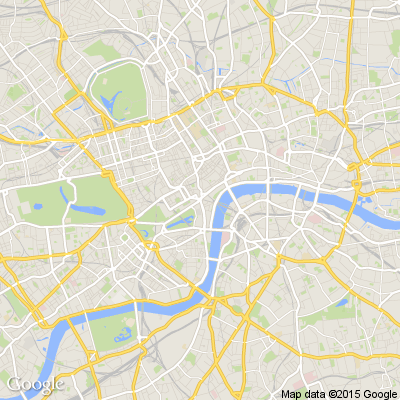

In [17]:
IPython.core.display.Image(map_png)

Now we get to our research project: we want to find out how urbanised the world is, based on satellite imagery, along a line
    between two cites. We expect the satellite image to be greener in the countryside.

Let's define what we count as green:

In [23]:
def is_green(red, green, blue):
  threshold=1.1
  return green>red*threshold and green>blue*threshold

We'll use lots more libraries to count how much green there is in an image. This is where you'll definitely stop following if you're new to this. Don't worry. The point is to get a feel for where we're headed.

In [24]:
import png # A library to work with PNG images https://pypi.python.org/pypi/pypng
from itertools import izip # A library to help us loop through each pixel
from StringIO import StringIO # A library to convert between files and strings
def count_green_in_png(data):
    image=png.Reader(file=StringIO(data)).asRGB()
    count = 0
    for row in image[2]:
        pixels=izip(*[iter(row)]*3)
        count+=sum(1 for pixel in pixels if is_green(*pixel))
    return count


In [25]:
print count_green_in_png(map_at(*london_location))

12286


And to display the green content to check our work:

In [26]:
def show_green_in_png(data):
    image=png.Reader(file=StringIO(data)).asRGB()
    count = 0
    out=[]
    for row in image[2]:
        outrow=[]
        pixels=izip(*[iter(row)]*3)
        for pixel in pixels:
            outrow.append(0)
            if is_green(*pixel):
                outrow.append(255)
            else:
                outrow.append(0)
            outrow.append(0)
        out.append(outrow)
    buffer=StringIO()
    result = png.from_array(out,mode='RGB')
    result.save(buffer)
    return buffer.getvalue()

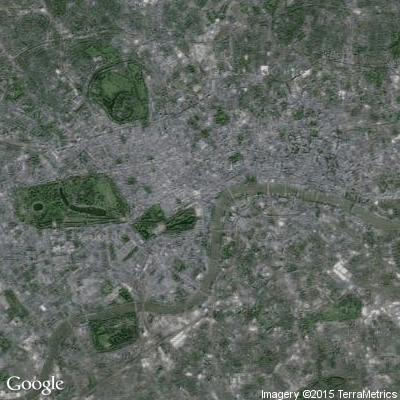

In [27]:
IPython.core.display.Image(
    map_at(*london_location,satellite=True)
)

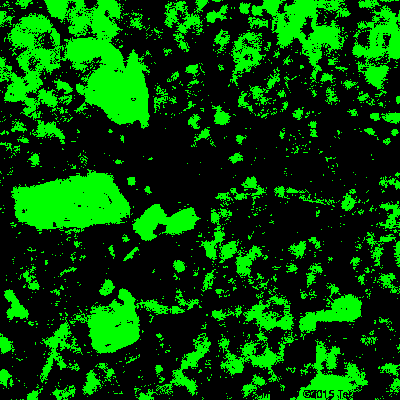

In [28]:
IPython.core.display.Image(
    show_green_in_png(
        map_at(
            *london_location,
            satellite=True)))

Now let's write a function to get an evenly spaced set of places between two places:

In [29]:
from numpy import linspace
def location_sequence(start,end,steps):
  # Would actually prefer this if steps
  # were deduced from zoomlevel
  # But need projection code for that
  lats=linspace(start[0],end[0],steps)
  longs=linspace(start[1],end[1],steps)
  return zip(lats,longs)

In [30]:
location_sequence(geolocate("London"), geolocate("Cambridge"),10)

[(51.507350899999999, -0.12775829999999999),
 (51.58490491111111, -0.1000277111111111),
 (51.662458922222221, -0.072297122222222204),
 (51.740012933333333, -0.044566533333333325),
 (51.817566944444444, -0.016835944444444431),
 (51.895120955555555, 0.010894644444444462),
 (51.972674966666666, 0.038625233333333342),
 (52.050228977777778, 0.066355822222222249),
 (52.127782988888889, 0.094086411111111129),
 (52.205337, 0.12181699999999999)]

###Looping

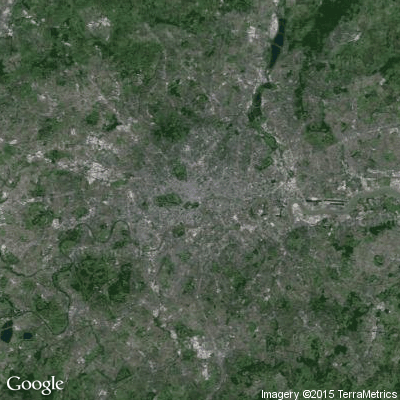

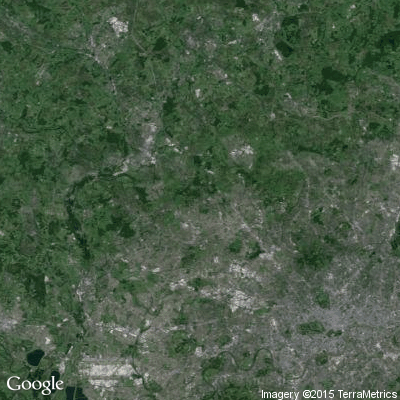

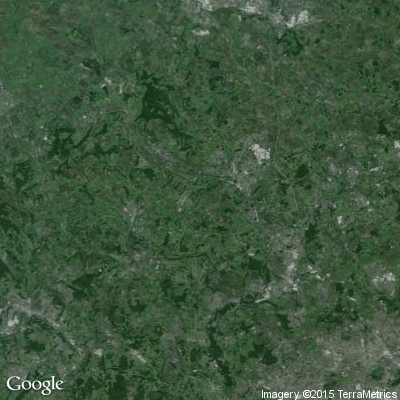

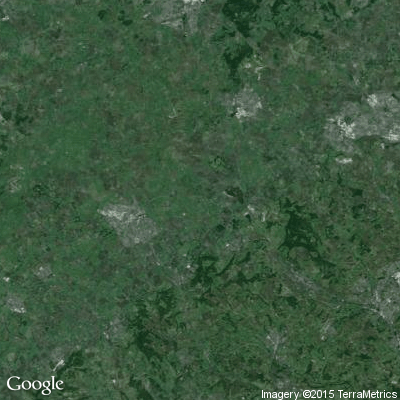

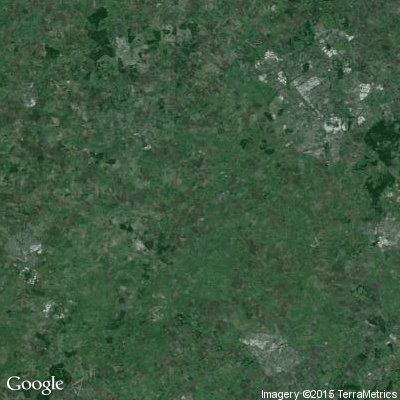

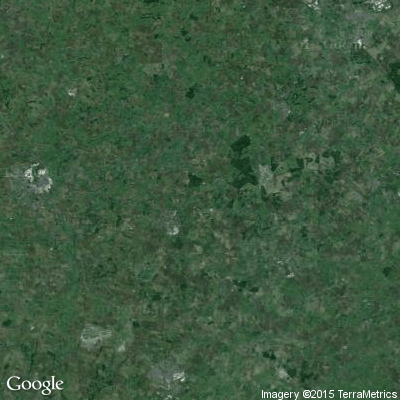

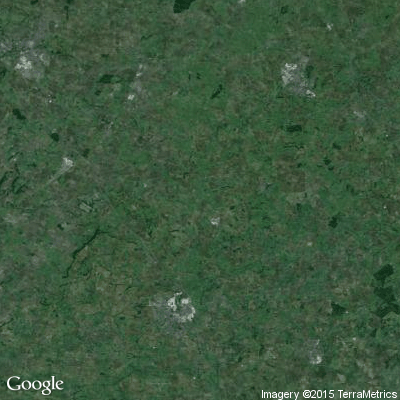

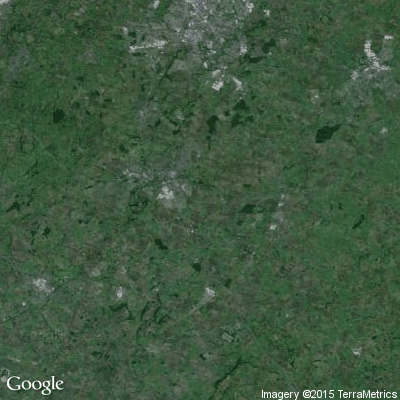

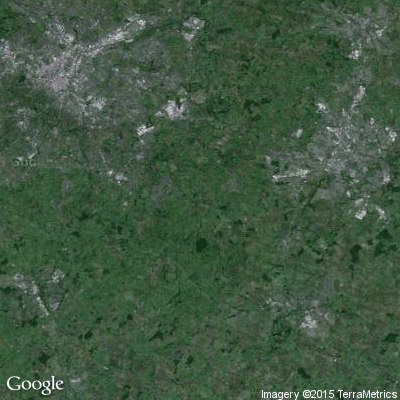

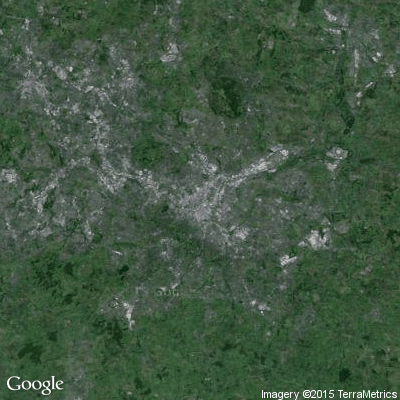

In [31]:
for location in location_sequence(geolocate("London"), geolocate("Birmingham"),10):
    IPython.core.display.display( IPython.core.display.Image(map_at(*location,zoom=10,satellite=True)))

So now we can count the green from London to Birmingham!

In [32]:
[count_green_in_png(map_at(*location,zoom=10,satellite=True))
            for location in location_sequence(geolocate("London"),geolocate("Birmingham"),10)]

[106806,
 127985,
 157091,
 158679,
 158033,
 158833,
 158561,
 156501,
 149482,
 140037]

In [33]:
### Plotting

Let's plot a graph.

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

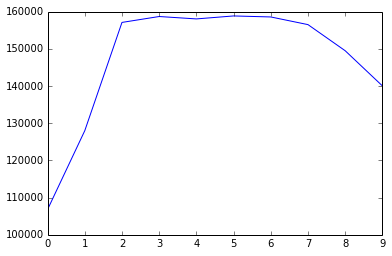

In [35]:
plt.plot([count_green_in_png(map_at(*location,zoom=10,satellite=True))
            for location in location_sequence(geolocate("London"),geolocate("Birmingham"),10)])

From a research perspective, of course, this code needs a lot of work. But I hope the power of using programming is clear.


We built little pieces of useful code, to:
* Find latitude and longitude of a place
* Get a map at a given latitude and longitude
* Decide whether a (red,green,blue) triple is mainly green
* Decide whether each pixel is mainly green
* Plot a new image showing the green places
* Find evenly spaced points between two places

By putting these together, we can make a function which can plot this graph automatically for any two places:

In [36]:
def green_between(start, end,steps):
    return [count_green_in_png(map_at(*location,zoom=10,satellite=True))
            for location in location_sequence(geolocate(start),geolocate(end),steps)]

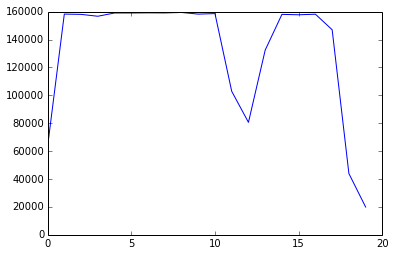

In [37]:
plt.plot(green_between('New York','Chicago',20))

And that's it! We've covered, very very quickly, the majority of the python language, and much of the theory of software engineering.

Now we'll go back, carefully, through all the concepts we touched on, and learn how to use them properly ourselves.